In [9]:
"""Import relevant libraries"""
import os
import numpy as np
import pandas as pd
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt # Not necessary in Jupyter Notebook

In [16]:
"""User Input"""
### Values that are entered and stored in the code for easy recall
file = 'od_data.xlsx'
firstrow = 28
lastrow = 108
firstcolumn = 3
lastcolumn = 35
col_names_row = 27
index_column = 1

invalid_resp = True # while loop control variable

while invalid_resp: # Loops if 'neworold' input is invalid
    ### Shows current code-stored file and asks if the user would like to choose another
    neworold = input(f'Current stored file is {file}\nWould you like to select a new file? (y/n)\n: ').lower() # Make sure the input is lowercase

    if neworold == 'y':      # If a new file is being selected
        invalid_resp = False # A valid response has been entered
        
        while True: # Loops if 'file' input is invalid
            try:
                file = input('Excel File Name: ')
                file_path = os.path.realpath(file) # Gets the full file path. If the file doesn't exist, exception is raised
                break
                ### This code can be used for file selection prompt, if it is prefered over manual user input
#                 root = tk.Tk()
#                 root.withdraw()
#                 file_path = filedialog.askopenfilename(initialdir= os.getcwd(),
#                                                         title= "Please select a file:",
#                                                         filetypes = ('Excel Files','*.xlsx *.xls'))
            except:
                print('Invalid file')
        
        while True: # Loops if any of the following inputs is not an integer
            try:
                firstrow = int(input('Enter the first row number (1, 9, 23, etc.): '))
                lastrow = int(input('Enter the last row number (1, 9, 23, etc.): '))
                firstcolumn = int(input('Enter the first column number (1, 9, 23, etc.): '))
                lastcolumn = int(input('Enter the last column number (1, 9, 23, etc.): '))
                col_names_row = int(input('Enter the number (1, 9, 23, etc.) of the row with the column labels: '))
                index_column = int(input('Enter the number (1, 9, 23, etc.) of the index column: '))
                break
            except:
                print('Invalid input')
              
    elif neworold == 'n':                  # If the code-stored file is being used
        file_path = os.path.realpath(file) # Gets full file path and checks if the file is valid
        invalid_resp = False               # A valid response has been entered
    else:
        print('Invalid input!\nPlease respond with \"y\" or \"n\"')

Current stored file is od_data.xlsx
Would you like to select a new file? (y/n)
: n


In [17]:
"""Import excel file"""
df = pd.read_excel(file_path,header = None,engine="openpyxl") # Read excel file and store as a pandas dataframe

In [18]:
"""Data cleaning"""
'''Data extraction'''
data = df.loc[firstrow:lastrow, firstcolumn:lastcolumn]       # Select out the relevant data & store in new dataframe
data.columns = df.loc[col_names_row, firstcolumn:lastcolumn]  # Set approriate column names by calling them from df dataframe
data.index = df.loc[firstrow:lastrow, index_column]           # Set approriate row names by calling them from df dataframe
# data.index.name = None                                      # Can be used to erase the index column name, if desired
data = data.dropna(axis=1, thresh=int(len(data) / 2) + 1)     # Drops all columns where more than half of the values are not valid

'''User input exceptions'''
while True: # Loops if 'drop_names' input is invalid or the user isn't finished inputting
    try:
        drop_names = input('Enter the name(s) of the column(s) that do not contain data.\nPress \'enter\' after each entry.\nEnter \"done\" when finished.\n: ')
        if drop_names.lower() == 'done': # If the user is done entering values...
            break                        # Break the loop
        data.drop(columns=drop_names)    # Otherwise, drop the specified columns
    except:
        print('Invalid Input')

while True: # Loops if 'wells' input is invalid
    try:
        wells = int(input('How many wells?\nEnter as a positive integer (e.g. 1,2,5, etc.)\n: '))
        break
    except:
        print('Invalid input')

nc_wells = [] # Initialize list
while True:   # Loops if 'nc_well' input is invalid or the user isn't finished inputting
    try:
        nc_well = input('Enter the number(s) (1, 2, etc.) of the wells that include the negative control(s).\nPress \'enter\' after each entry.\nEnter \"done\" when finished.\n: ')
        if nc_well.lower() == 'done': # If the user is done entering values...
            break                     # Break the loop
        int(nc_well)                  # Otherwise, check is the input is an integer
        nc_wells.append(nc_well)      # If so, add it to the list
    except:
        print('Invalid input')

Enter the name(s) of the column(s) that do not contain data.
Press 'enter' after each entry.
Enter "done" when finished.
: done
How many wells?
Enter as a positive integer (e.g. 1,2,5, etc.)
: 3
Enter the number(s) (1, 2, etc.) of the wells that include the negative control(s).
Press 'enter' after each entry.
Enter "done" when finished.
: 1
Enter the number(s) (1, 2, etc.) of the wells that include the negative control(s).
Press 'enter' after each entry.
Enter "done" when finished.
: 2
Enter the number(s) (1, 2, etc.) of the wells that include the negative control(s).
Press 'enter' after each entry.
Enter "done" when finished.
: done


In [19]:
"""Calculate & build final data"""

'''Initialize useful dictionary and dataframe'''
avg = {}                   # Used to iteratively set variables
OD_data = pd.DataFrame({}) # Scaffold for final dataframe

letters = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ') # Establish letters to be used to the specified number of wells

'''Perform calculations'''
### It is assumed that the first samples in each well are the neg. controls
avg['avg1'] = 0                                        # Initialize the first group
for nc in nc_wells:                                    # for each specified well with the neg. controls...
    avg['avg1'] += data[letters[int(nc)-1]+'1'].values # The group equals itself plus the next neg. control sample
avg['avg1'] /= len(nc_wells)                           # Divide the values by the number of samples to get the average
OD_data['Control Group 1'] = avg['avg1']               # Add the control group to the new dataframe

### Repeat above process iteratively for the rest of the groups, this time from all 3 samples
for n in range(1,int(len(data.columns)/wells)):
    avg['avg'+str(n+1)] = 0
    for well in range(wells):
        avg['avg'+str(n+1)] += data[letters[well]+str(n+1)].values
    avg['avg'+str(n+1)] /= wells
    OD_data['Group '+str(n+1)] = avg['avg'+str(n+1)] # Call previously stored data from dict. and add it to OD_data dataframe

OD_data.index = data.index # Transfer index from old dataframe

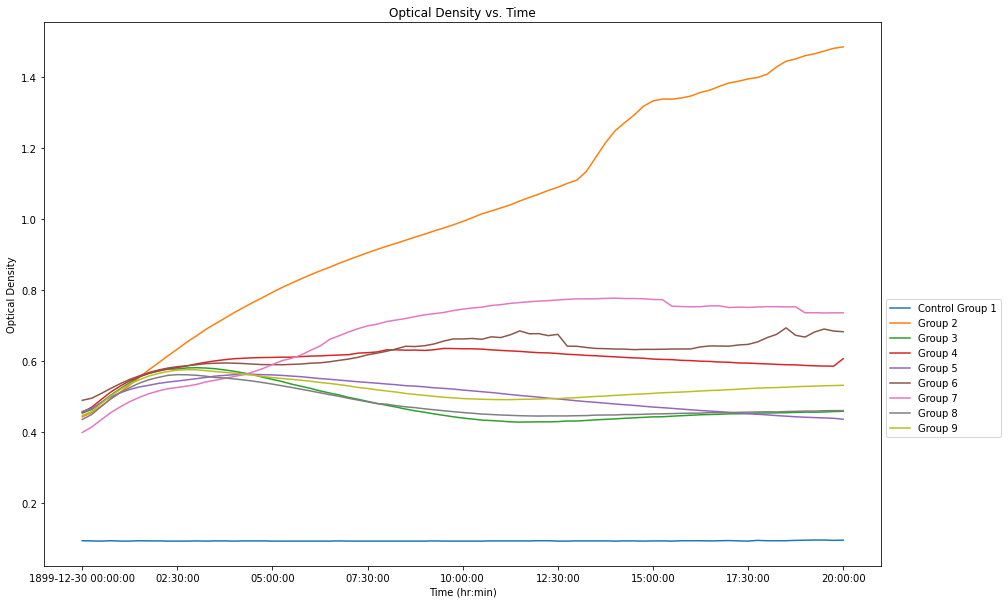

In [20]:
"""Display data plot"""
OD_data.plot(figsize=(15,10),                                   # Initialize plot from dataframe with x to y ratio of 15:10
             title = 'Optical Density vs. Time',                # Set title
             xlabel = 'Time (hr:min)',                          # Set x-axis label
             ylabel = 'Optical Density',                        # Set y-axis label
#              xticks = ['00:00','05:00','10:00','15:00','20:00'] # Set x-axis ticks
            ).legend(bbox_to_anchor=(1, 0.5))                   # Set top left of the legend to center right of the plot
plt.show()                                                      # Show the plot (not necessary in Jupyter Notebook)